In [1]:
import os
## lazy imports ala fastai2 style (needed for nice print functionality)
from fastai.basics import *
from fastai.tabular.all import *

## import my own code
from make_dataset import load_from_file, tabularize_univariate
from utils import pad_ar_params, estimate_noise, split_by_p_valid, nice_print_list
from utils import compute_sTPE, coeff_from_model
from plotting import plot_weights, plot_prediction_sample, plot_error_scatter
from ar_net import init_ar_learner

%matplotlib inline

In [2]:
## notebook settings
verbose = True
save = True
created_ar_data = True

data_path = '../ar_data'
data_name = 'ar_3_ma_0_noise_0.100_len_10000'
results_path = '../results'

In [3]:
## Load data
if created_ar_data:
    ## if created AR data with create_ar_data, we can use the helper function:
    df, data_config = load_from_file(data_path, data_name, load_config=True, verbose=verbose)
else:
    ## else we can manually load any file that stores a time series, for example:
    df = pd.read_csv(os.path.join(data_path, data_name + '.csv'), header=None, index_col=False)

loaded series from file
data_config {'samples': 10000, 'noise_std': 0.1, 'ar_order': 3, 'ma_order': 0, 'ar_params': [0.2, 0.3, -0.5], 'ma_params': []}
(10000, 1)
          0
0  0.039932
1 -0.012868
2  0.204913
3  0.072726
4  0.048572


In [4]:
#### Hyperparameters
n_epoch = 20
valid_p = 0.5
n_forecasts = 1  # Note: if more than one, must have a list of ar_param for each forecast target.
sparsity = 0.3  # guesstimate
ar_order = 10  # guesstimate

ar_params = None
## if we know the true AR parameters:
if created_ar_data: 
    ## for normal AR:
    ar_order = int(data_config["ar_order"])
    ## for sparse AR:
    ar_order = int(1/sparsity * data_config["ar_order"])     
    ## to compute stats
    ar_params = pad_ar_params([data_config["ar_params"]], ar_order, n_forecasts)

In [5]:
#### Init Model
learn = init_ar_learner(
    series=df,
    ar_order=ar_order,
    n_forecasts=n_forecasts,
    valid_p=valid_p,
    sparsity=sparsity,
    ar_params=ar_params,
    verbose=verbose,
)

tabularized df
df columns ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_0']
df shape (9990, 11)
estimated noise of series 0.13183412988991614
split on idx:  4995
split sizes:  [4995, 4995]
cont var num 10 ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']
reg lam:  0.006152259394862753
TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)


0.1258925437927246


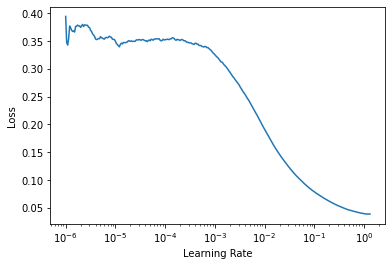

In [6]:
## find Learning Rate
lr_at_min, _ = learn.lr_find(start_lr=1e-6, end_lr=1e2, num_it=400)
print(lr_at_min)

In [7]:
#### Run Model
## if you know the best learning rate:
# learn.fit(n_epoch, 1e-2)
## else use onecycle
learn.fit_one_cycle(n_epoch=n_epoch, lr_max=lr_at_min/10)

epoch,train_loss,valid_loss,mae,sTPE of AR coeff,time
0,0.117468,0.051510,0.181514,82.433941,00:00
1,0.020380,0.011290,0.084967,83.339330,00:00
2,0.013262,0.010961,0.083553,82.892437,00:01
3,0.012802,0.011345,0.085417,81.435960,00:01
4,0.012997,0.011389,0.085200,86.398474,00:01
5,0.013232,0.010728,0.082831,78.878786,00:01
6,0.013056,0.010455,0.081786,77.380900,00:01
7,0.013125,0.011047,0.084133,80.406523,00:01
8,0.012866,0.010425,0.081658,79.264826,00:01
9,0.013614,0.010706,0.082796,80.474270,00:00


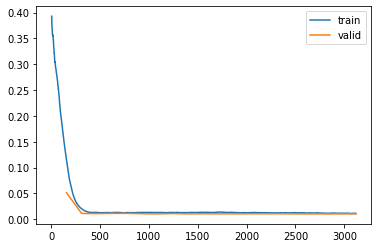

In [8]:
learn.recorder.plot_loss()

In [9]:
#### Look at Coeff
coeff = coeff_from_model(learn.model)
if created_ar_data: print("ar params", nice_print_list(ar_params))
print("model weights", nice_print_list(coeff))
# should be [0.20, 0.30, -0.50, ...]

ar params [['0.200', '0.300', '-0.500', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']]
model weights [['0.029', '0.043', '-0.070', '-0.000', '-0.000', '-0.000', '-0.000', '-0.000', '-0.002', '0.000']]


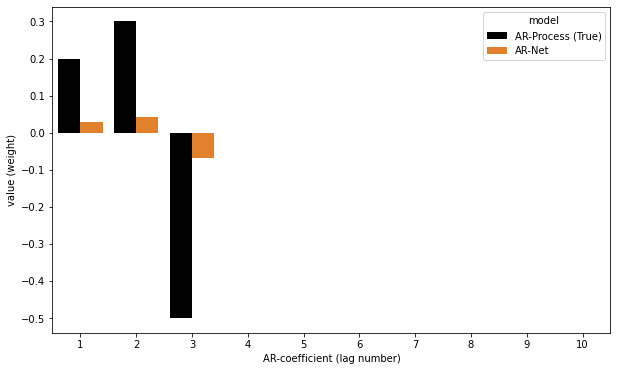

In [10]:
if created_ar_data: 
    plot_weights(
        ar_val=len(ar_params[0]),
        weights=coeff[0],
        ar=ar_params[0],
        save=save,
        savedir=results_path
    )

In [11]:
preds, y = learn.get_preds()

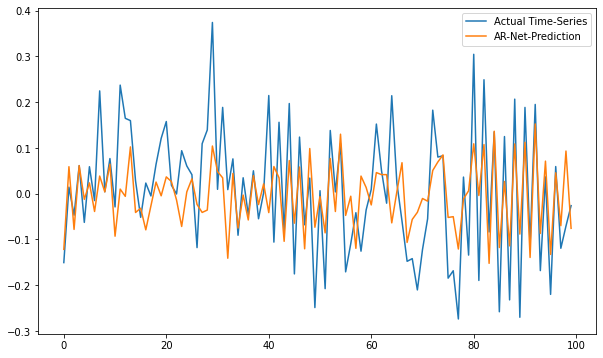

In [12]:
plot_prediction_sample(preds, y, num_obs=100, save=save, savedir=results_path)

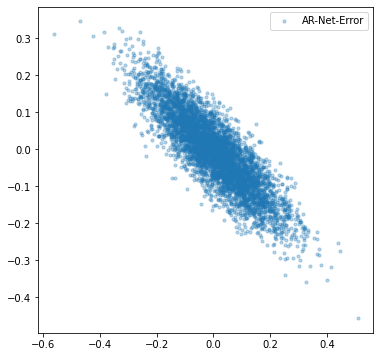

In [13]:
plot_error_scatter(preds, y, save=save, savedir=results_path)

In [14]:
#### Extras ####

In [15]:
## Optional:save and create inference learner
if save:
    learn.freeze()
    if not os.path.exists(results_path): os.makedirs(results_path)
    model_name = "ar{}_sparse_{:.3f}_ahead_{}_epoch_{}.pkl".format(ar_order, sparsity, n_forecasts, n_epoch)
    learn.export(fname=os.path.join(results_path, model_name))
    ## can be loaded like this
    infer = load_learner(fname=os.path.join(results_path, model_name), cpu=True)

In [16]:
## can unfreeze the model and fine_tune
learn.unfreeze()
learn.fit_one_cycle(10, lr_at_min/100)

epoch,train_loss,valid_loss,mae,sTPE of AR coeff,time
0,0.011135,0.010369,0.081432,74.901259,00:00
1,0.011921,0.010397,0.081594,76.383941,00:00
2,0.011672,0.010436,0.081702,76.611052,00:00
3,0.011883,0.010515,0.082040,76.993270,00:01
4,0.011733,0.010444,0.081679,76.186249,00:01
5,0.011543,0.010370,0.081459,76.004455,00:00
6,0.011720,0.010430,0.081649,77.134500,00:00
7,0.011711,0.010429,0.081664,76.735726,00:00
8,0.011845,0.010374,0.081477,76.670437,00:00
9,0.011455,0.010420,0.081639,76.605048,00:00


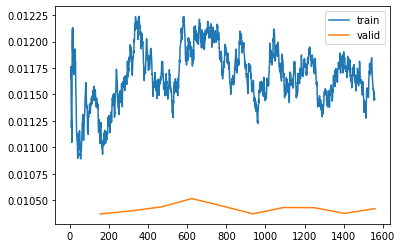

In [17]:
learn.recorder.plot_loss()

ar params [['0.200', '0.300', '-0.500', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']]
model weights [['0.029', '0.043', '-0.070', '-0.000', '-0.000', '-0.000', '-0.000', '-0.000', '-0.002', '0.000']]
model weights2 [['0.026', '0.040', '-0.067', '0.001', '-0.000', '-0.000', '0.000', '0.003', '0.001', '0.001']]


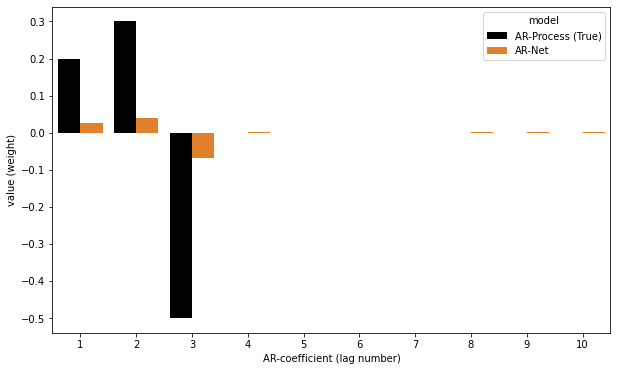

In [18]:
coeff2 = coeff_from_model(learn.model)
if created_ar_data: print("ar params", nice_print_list(ar_params))
print("model weights", nice_print_list(coeff))
print("model weights2", nice_print_list(coeff2))
if created_ar_data: 
    plot_weights(
        ar_val=len(ar_params[0]),
        weights=coeff2[0],
        ar=ar_params[0],
        save=save,
        savedir=results_path
    )